<h2>EYE FOR BLIND - Capstone Project</h2>
<h3>Problem Statement</h3>
<p>In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.  

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.</p>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/archive.zip > /dev/null

In [3]:
#Import all the required libraries
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns 
import glob

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

<h3>Data understanding</h3><br/>
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path

In [5]:
images='Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
len(all_imgs)

8091

In [6]:
#Import the dataset and read the text file into a seperate variable

text_file = 'captions.txt'
open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
text = open_file.read()



In [7]:
image_path='Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID                              Path  \
0      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
...                          ...                               ...   
40450   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [8]:
#Create the vocabulary & the counter for the captions
vocabulary= [word.lower() for line in annotations for word in line.split()] #We can see that we had both

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

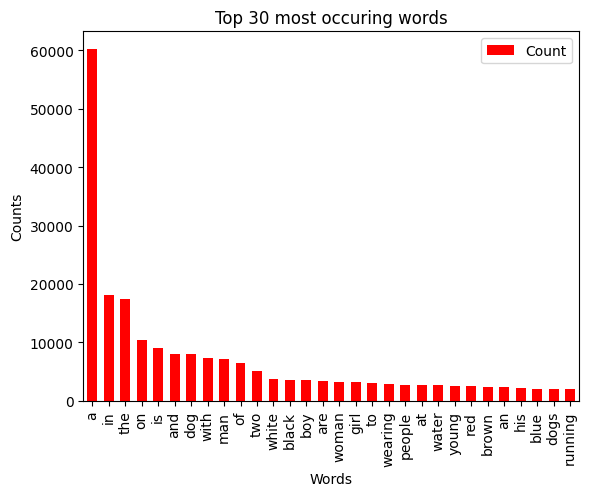

In [9]:
import collections
val_count=collections.Counter(vocabulary)

#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
words_df = {word: count for  word, count in val_count.most_common(30) if word not in stopwords}
words_df



{'dog': 7948,
 'man': 7137,
 'two': 5132,
 'white': 3706,
 'black': 3620,
 'boy': 3514,
 'woman': 3304,
 'girl': 3277,
 'wearing': 2916,
 'people': 2811,
 'water': 2676,
 'young': 2587,
 'red': 2553,
 'brown': 2457,
 'blue': 2125,
 'dogs': 2095,
 'running': 1996}

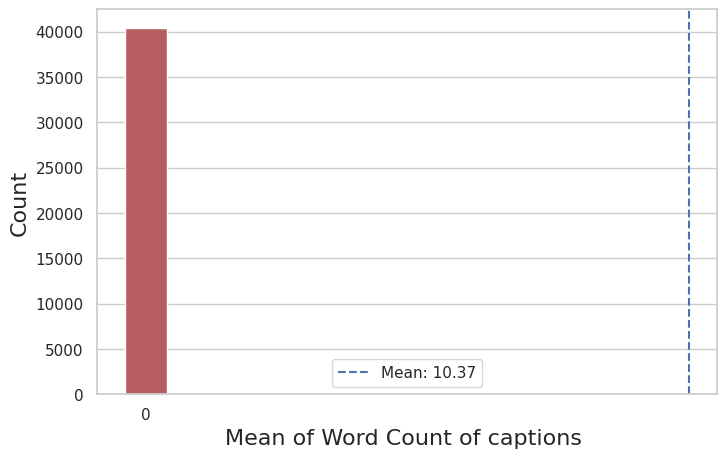

In [12]:
caption_df=df.copy()
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

mean = sum(caption_df['caption_word_count'])/len(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")
plt.xlabel('Mean of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})

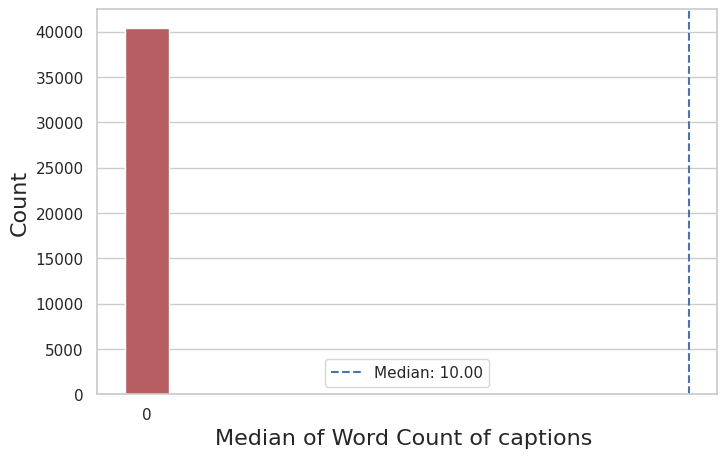

In [13]:
mean = np.median(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")
plt.xlabel('Median of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Median: {:.2f}'.format(mean): mean})

<h3>Until now we visualized the images and captions separately.Now let's visualize both of them together.</h3>

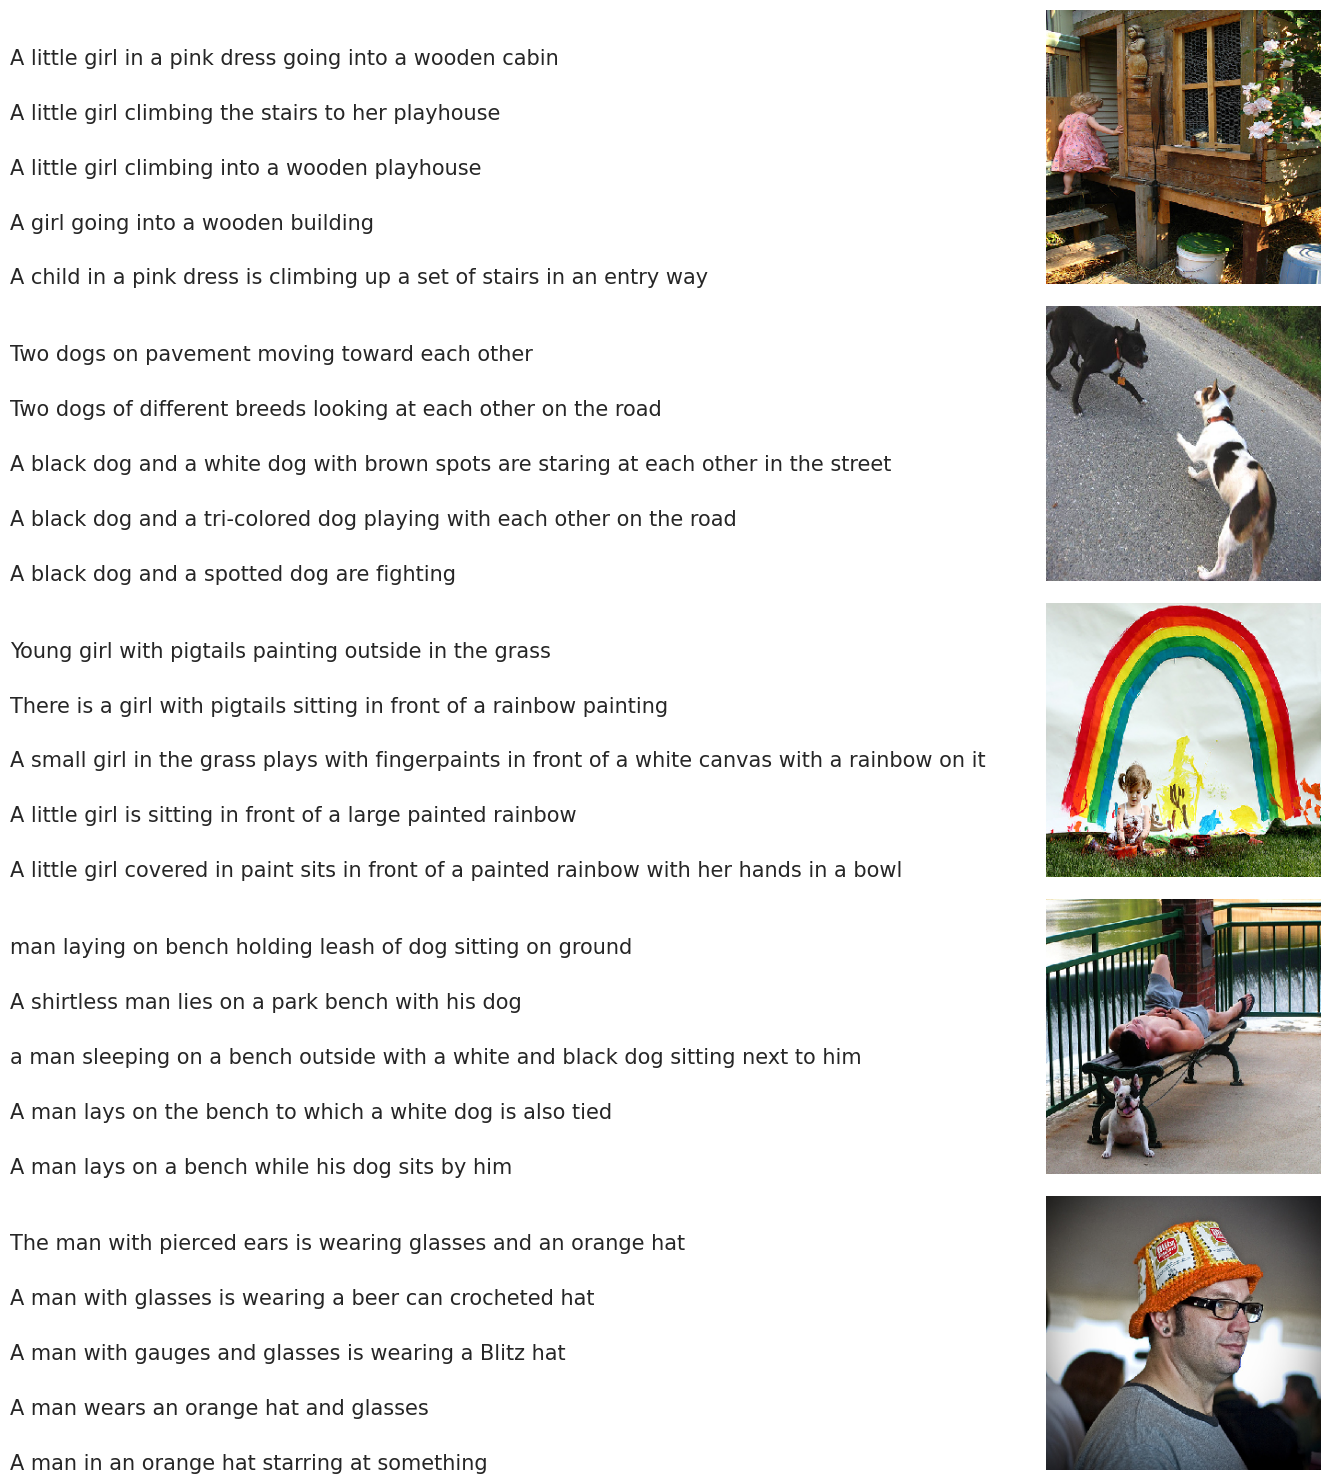

In [14]:
fig = plt.figure(figsize=(15,15)) # For displaying image
count = 1
    
for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()

<h3>Data Cleaning</h3><br/>
Converting all words to lower case
Removing punctuations
Retaining only words by removing numbers
We are not removing stopwords but removing hanging s ,a or any one letter word.
We are not performing stemming.

In [15]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line) 

In [16]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

<h3>Pre-Processing the captions</h3><br/>
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

<h3>Create the tokenizer</h3><br/>
We have already removed numeric character in previous step.

Let's remove punctuations using filter again for to be sure(The default is all punctuation, plus tabs and line breaks, minus the ' character.)

Convert words to lower case (this is also already done.Let's do again to be safe)

And,replace out-of-vocabulary words with UNK token and assign PAD token for reseved zero index

In [17]:
top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")


# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


Text(0, 0.5, 'Counts')

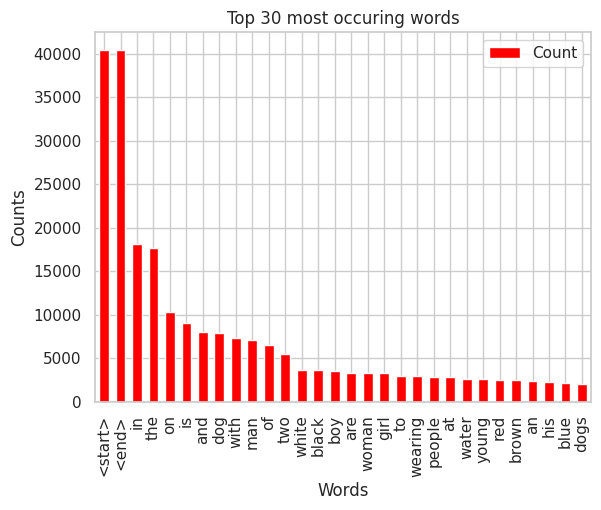

In [18]:
# Create a word count of your tokenizer to visualize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")


In [19]:
# Pad each vector to the max_length of the captions ^ store it to a variable

train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


<p>We are padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat. Zero indicates no word and have no value at beginning.So,in order to not disturb the existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then.</p>

<h3>Pre-processing the images</h3><br/>
1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [20]:
tf.keras.backend.image_data_format()
IMAGE_SHAPE= (120, 120)


#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Shape after resize : (120, 120, 3)
Shape after resize : (120, 120, 3)
Shape after resize : (120, 120, 3)
Shape after resize : (120, 120, 3)
Shape after resize : (120, 120, 3)


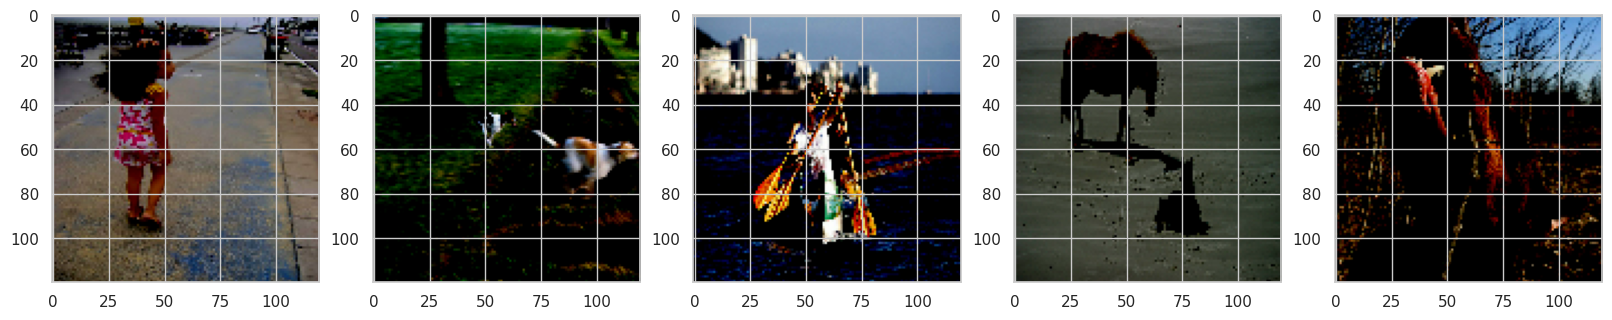

In [21]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

<p>Let's write a function for preprocessing and return images and it's path so that we can use concept of <b>*vectorization and preprocess images paralleley rather than writing for loop*</b>.</p>

In [22]:
def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

<h3>Create the train & test data</h3><br/>
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [23]:
# mapping each image full path including name to the function to preprocess the image
# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [24]:
# performing the train-test spliit using 80-20 ratio & random state = 42
img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

<h3>Load the pretrained Imagenet weights of Inception net V3</h3><br/>
1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

<b>Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.</b>

In [25]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

87910968/87910968 [==============================] - 3s 0us/step


<p>We are not classifying the images here. Rather,we only need to extract an image vector for our images.Hence we are removing the softmax layer from the model.</p>

In [26]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [27]:
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64 ##tried with different batch sizes.kernal is dieing for 32 .So finally fixed 64.

def data_generator(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [28]:
# write your code to extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|██████████| 127/127 [01:22<00:00,  1.55it/s]


In [29]:
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [30]:
train_dataset=data_generator(img_train_data,caption_train_data) 
test_dataset=data_generator(img_test_data,caption_test_data) 

<h3>Model Building</h3><br/>
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [31]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

<h3>Encoder</h3>

In [32]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

encoder=Encoder(embedding_dim)

<h3>Attention model</h3>

In [33]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

<p>The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated

In other words, the tanh function is introduced to do non linear transformation and give smooth output .Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

Finally we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector.

This context vector produced are adaptive as they change for each and every time stamp.</p>

<h3>Decoder</h3>

In [34]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


decoder=Decoder(embedding_dim, units, vocab_size)

<p>We know that the encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.After passing the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.</p>

In [35]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))


In [36]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)



Feature shape from Encoder: (64, 4, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 4, 1)


<h3>Model training & optimization</h3><br/>
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [37]:
optimizer =tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [38]:

checkpoint_path = "checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [40]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

In [41]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

<p>We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model are very bad. If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the next input to the decoder</p>

In [42]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [43]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.543, & test loss is 1.286
Time taken for 1 epoch 170.4401090145111 sec

Test loss has been reduced from 100.000 to 1.286


  3%|▎         | 1/30 [02:50<1:22:31, 170.73s/it]

For epoch: 2, the train loss is 1.198, & test loss is 1.146
Time taken for 1 epoch 42.92065763473511 sec

Test loss has been reduced from 1.286 to 1.146


  7%|▋         | 2/30 [03:33<44:38, 95.68s/it]   

For epoch: 3, the train loss is 1.099, & test loss is 1.067
Time taken for 1 epoch 41.49195075035095 sec

Test loss has been reduced from 1.146 to 1.067


 10%|█         | 3/30 [04:15<31:58, 71.04s/it]

For epoch: 4, the train loss is 1.029, & test loss is 1.002
Time taken for 1 epoch 41.01012468338013 sec

Test loss has been reduced from 1.067 to 1.002


 13%|█▎        | 4/30 [04:56<25:41, 59.29s/it]

For epoch: 5, the train loss is 0.969, & test loss is 0.947
Time taken for 1 epoch 42.0993857383728 sec

Test loss has been reduced from 1.002 to 0.947


 17%|█▋        | 5/30 [05:39<22:09, 53.20s/it]

For epoch: 6, the train loss is 0.916, & test loss is 0.894
Time taken for 1 epoch 41.71240472793579 sec

Test loss has been reduced from 0.947 to 0.894


 20%|██        | 6/30 [06:21<19:45, 49.40s/it]

For epoch: 7, the train loss is 0.869, & test loss is 0.849
Time taken for 1 epoch 40.59494996070862 sec

Test loss has been reduced from 0.894 to 0.849


 23%|██▎       | 7/30 [07:02<17:51, 46.60s/it]

For epoch: 8, the train loss is 0.827, & test loss is 0.808
Time taken for 1 epoch 40.94675040245056 sec

Test loss has been reduced from 0.849 to 0.808


 27%|██▋       | 8/30 [07:43<16:27, 44.87s/it]

For epoch: 9, the train loss is 0.790, & test loss is 0.772
Time taken for 1 epoch 40.606661796569824 sec

Test loss has been reduced from 0.808 to 0.772


 30%|███       | 9/30 [08:24<15:15, 43.61s/it]

For epoch: 10, the train loss is 0.756, & test loss is 0.742
Time taken for 1 epoch 40.83470296859741 sec

Test loss has been reduced from 0.772 to 0.742


 33%|███▎      | 10/30 [09:05<14:16, 42.82s/it]

For epoch: 11, the train loss is 0.728, & test loss is 0.713
Time taken for 1 epoch 41.031073570251465 sec

Test loss has been reduced from 0.742 to 0.713


 37%|███▋      | 11/30 [09:46<13:24, 42.34s/it]

For epoch: 12, the train loss is 0.701, & test loss is 0.689
Time taken for 1 epoch 40.835259437561035 sec

Test loss has been reduced from 0.713 to 0.689


 43%|████▎     | 13/30 [11:08<11:48, 41.66s/it]

For epoch: 13, the train loss is 0.680, & test loss is 0.665
Time taken for 1 epoch 40.80731534957886 sec

Test loss has been reduced from 0.689 to 0.665
For epoch: 14, the train loss is 0.657, & test loss is 0.645
Time taken for 1 epoch 40.91998219490051 sec

Test loss has been reduced from 0.665 to 0.645


 47%|████▋     | 14/30 [11:49<11:04, 41.50s/it]

For epoch: 15, the train loss is 0.638, & test loss is 0.626
Time taken for 1 epoch 40.61522436141968 sec

Test loss has been reduced from 0.645 to 0.626


 50%|█████     | 15/30 [12:30<10:19, 41.30s/it]

For epoch: 16, the train loss is 0.623, & test loss is 0.611
Time taken for 1 epoch 40.4850640296936 sec

Test loss has been reduced from 0.626 to 0.611


 53%|█████▎    | 16/30 [13:11<09:35, 41.12s/it]

For epoch: 17, the train loss is 0.607, & test loss is 0.596
Time taken for 1 epoch 40.64518356323242 sec

Test loss has been reduced from 0.611 to 0.596


 57%|█████▋    | 17/30 [13:52<08:53, 41.05s/it]

For epoch: 18, the train loss is 0.591, & test loss is 0.580
Time taken for 1 epoch 40.829553842544556 sec

Test loss has been reduced from 0.596 to 0.580


 60%|██████    | 18/30 [14:33<08:12, 41.04s/it]

For epoch: 19, the train loss is 0.578, & test loss is 0.569
Time taken for 1 epoch 40.08912754058838 sec

Test loss has been reduced from 0.580 to 0.569


 63%|██████▎   | 19/30 [15:13<07:29, 40.83s/it]

For epoch: 20, the train loss is 0.566, & test loss is 0.554
Time taken for 1 epoch 40.85886573791504 sec

Test loss has been reduced from 0.569 to 0.554


 67%|██████▋   | 20/30 [15:54<06:48, 40.90s/it]

For epoch: 21, the train loss is 0.553, & test loss is 0.544
Time taken for 1 epoch 40.75423884391785 sec

Test loss has been reduced from 0.554 to 0.544


 70%|███████   | 21/30 [16:35<06:08, 40.92s/it]

For epoch: 22, the train loss is 0.542, & test loss is 0.531
Time taken for 1 epoch 40.28748822212219 sec

Test loss has been reduced from 0.544 to 0.531


 73%|███████▎  | 22/30 [17:15<05:26, 40.80s/it]

For epoch: 23, the train loss is 0.533, & test loss is 0.522
Time taken for 1 epoch 40.72685098648071 sec

Test loss has been reduced from 0.531 to 0.522


 77%|███████▋  | 23/30 [17:56<04:45, 40.84s/it]

For epoch: 24, the train loss is 0.521, & test loss is 0.512
Time taken for 1 epoch 40.713863372802734 sec

Test loss has been reduced from 0.522 to 0.512


 80%|████████  | 24/30 [18:37<04:05, 40.89s/it]

For epoch: 25, the train loss is 0.514, & test loss is 0.504
Time taken for 1 epoch 40.899333238601685 sec

Test loss has been reduced from 0.512 to 0.504


 83%|████████▎ | 25/30 [19:19<03:24, 40.98s/it]

For epoch: 26, the train loss is 0.505, & test loss is 0.498
Time taken for 1 epoch 40.92988085746765 sec

Test loss has been reduced from 0.504 to 0.498


 87%|████████▋ | 26/30 [20:00<02:44, 41.06s/it]

For epoch: 27, the train loss is 0.497, & test loss is 0.487
Time taken for 1 epoch 40.77994155883789 sec

Test loss has been reduced from 0.498 to 0.487


 90%|█████████ | 27/30 [20:41<02:03, 41.07s/it]

For epoch: 28, the train loss is 0.489, & test loss is 0.480
Time taken for 1 epoch 40.2741174697876 sec

Test loss has been reduced from 0.487 to 0.480


 93%|█████████▎| 28/30 [21:22<01:21, 40.92s/it]

For epoch: 29, the train loss is 0.482, & test loss is 0.474
Time taken for 1 epoch 40.41692018508911 sec

Test loss has been reduced from 0.480 to 0.474


 97%|█████████▋| 29/30 [22:02<00:40, 40.85s/it]

For epoch: 30, the train loss is 0.476, & test loss is 0.463
Time taken for 1 epoch 40.36622762680054 sec

Test loss has been reduced from 0.474 to 0.463


100%|██████████| 30/30 [22:43<00:00, 45.44s/it]


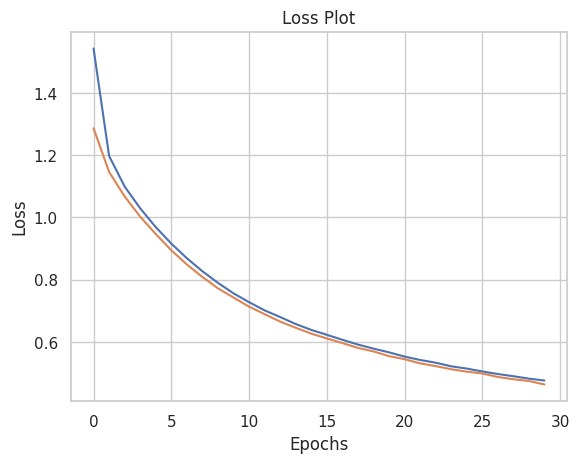

In [44]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()

<h3>Model Evaluation</h3><br/>
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

<h3>Greedy Search</h3>

In [45]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [46]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [47]:
def filt_text(text):
    filts=['<start>','<unk>','<end>'] 
    for filt in filts: text = text.replace(filt, '').strip() 
    return text

In [48]:
img_test=img_test_data.copy()

In [49]:
!pip install gTTs
!pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7019 sha256=42e0fe64ac9d803f891254dd12c180d311451a3092a0eb2d87fd918a99539a89
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


In [50]:
from pygame import mixer


pygame 2.3.0 (SDL 2.24.2, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [51]:
def predicted_caption(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]


    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    print ('Real Caption:',  filt_text(real_caption)  )
    print ('Prediction Caption:', filt_text(pred_caption)   )

    from gtts import gTTS
    from IPython.display import Audio 
    from IPython.core.display import display
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display(Audio(audio_file, autoplay=True))
    return test_image

Real Caption: two brown dogs fight on the leafy ground
Prediction Caption: two brown dog barks at another dog opens his mouth


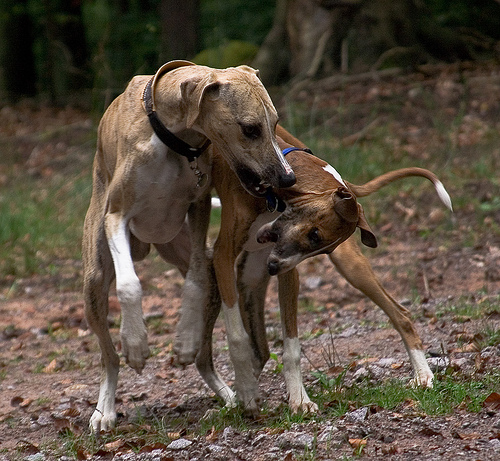

In [52]:
test_image=predicted_caption(5,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

Real Caption: two brown dogs fight on the leafy ground
Prediction Caption: two brown dog barks at another dog opens his mouth


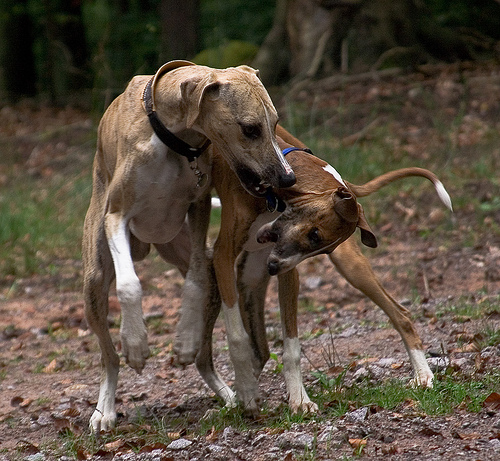

In [53]:
test_image=predicted_caption(5,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

Real Caption: two men dressed in white hit ball while third man walks up
Prediction Caption: these people in street under palm trees


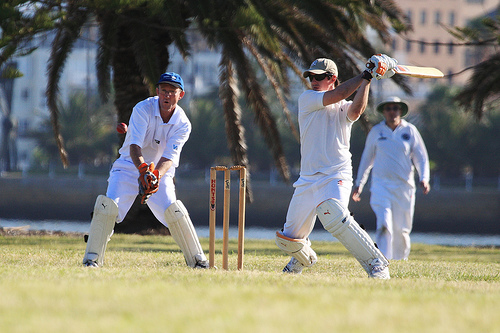

In [55]:
test_image=predicted_caption(11,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

Real Caption: the black and white dog is running on the grass
Prediction Caption: dog runs on the grass


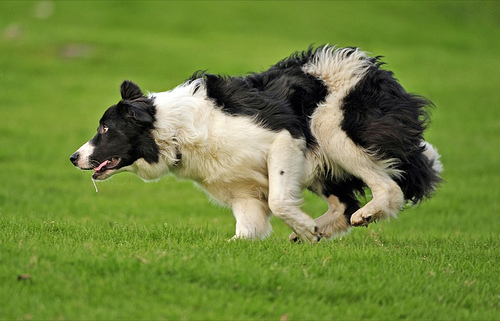

In [56]:
test_image=predicted_caption(20,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

Real Caption: large wild cat is pursuing horse across meadow
Prediction Caption: lioness closes in field


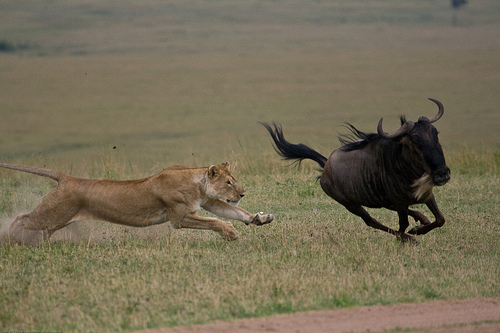

In [57]:
test_image=predicted_caption(20,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

Real Caption: skateboarder is riding on red ramp by the ocean
Prediction Caption: man doing trick on ramp


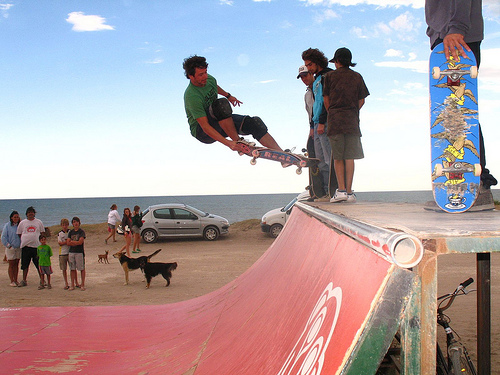

In [58]:
test_image=predicted_caption(20,True,weights=(0.5,0.25,0,0))
Image.open(test_image)

<h3>Summary:</h3><br/>
The project started with reading images and captions,displaying them.EDA is performed to understand about the given data set. Data cleaning is done which included cleaning caption file.

Data preprocessing is also performed which included :

tokenizing the captions and forming an embeded vector,
preprocessing images.
Post that a data set is splitted into train and test dataset.

InceptionV3 model is used.Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

Here in this project, we are not classifying the images. Rather,we only need to extract a featire vector for our images.Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).

This feature vector is given as input to CNN Encoder which had a single fully connected layer. To tell in abstract way,we can say that output from the encoder, hidden state(initialized to 0), and start token is passed as input to the decoder.

The decoder (RNN -here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. This also reduces noise and improves accuracy.The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.

The decoder stop predicting when the model predicts the end token.

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption